# Capstone Project: NYC Airbnb data clustering analysis and recommendation

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data Description](#data)
* [Modeling and analysis](#modeling)
* [Conclusion](#conclusion)


# 1. Introduction <a name="introduction"></a>

### 1.1 Background

I have been living in the New York City for 3 years and it has been a dream tour place for a lot of people. The prices of the hotels in the NYC is notoriusly high and as a result, while some people are rich enough, most people prefer to find alternative residences. Some of them decided to live far a way from the city and take a bus or train there for tour, while others chose to live in an Airbnb.

### 1.2 Problem

It is always hard to find a good Airbnb for travelers new to the New York City. There are a lot of factors to considers, such as food, neighbourhood, locations, house reviews, availabilities, and etc. Customers usually have to do intensive research on the locations to mine the information about the factors they care, and this could be time consuming. Often people relies on some online reviews or recommendations but his is also inefficient. In this case, a clustering of the house choices could be both commercially and economically valuable.

### 1.3 Methods

To create the model the recommendation system, I used the KMeans unsupervised learning to cluster the houses first, and then grouped their centroids, and choose centroids with the criterion from the customers, and generate recommendatin from the centroids for the customers

#  2. Data Descriptions <a name="data"></a>

### 2.1 Data Acquisition

The data comes from Kaggle.com, which is a platform for data science projects data as well as competitions. This datasets is originally from Airbnb website and is therefore an official data. It describes the 2019 Airbnb house providers' listing informations. (Link: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)
The data are the following:

    1. location data
    2. review data
    3. price data
    4. neighborhood data
    5. availability



### 2.2 Data Cleaning    

The Dataset from the the Kaggle about Airbnb data was separated into two tables, numerical data and categorical data. The two tables were normalized and encoded and then combined back into one tables for modeling. The main package of the whole cleaning process is Scikit-Learn

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb

%matplotlib inline

In [50]:

raw_data = pd.read_csv('AB_NYC_2019.csv')

### 2.3 Exploratory Data Analysis

In [51]:
raw_data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [52]:
from sklearn.preprocessing import MinMaxScaler
# scaling the numerical data
mms = MinMaxScaler()
eda_data_raw = raw_data.dropna().select_dtypes(exclude = ['object'])
eda_data = pd.DataFrame(mms.fit_transform(eda_data_raw))
eda_data.columns = eda_data_raw.columns.values.tolist()
eda_data.shape

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(38821, 10)

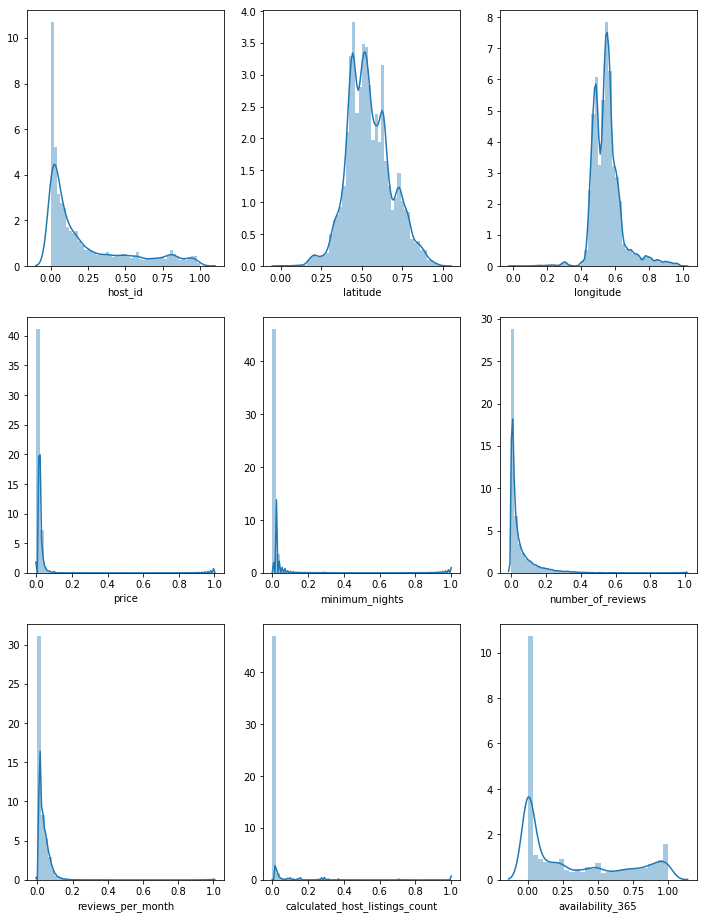

In [53]:

fig, axes = plt.subplots(3,3, figsize=(12, 16), sharex=False)
sb.distplot(eda_data.iloc[:,1], ax = axes[0, 0])
sb.distplot(eda_data.iloc[:,2], ax = axes[0, 1])
sb.distplot(eda_data.iloc[:,3], ax = axes[0, 2])
sb.distplot(eda_data.iloc[:,4], ax = axes[1, 0])
sb.distplot(eda_data.iloc[:,5], ax = axes[1, 1])
sb.distplot(eda_data.iloc[:,6], ax = axes[1, 2])
sb.distplot(eda_data.iloc[:,7], ax = axes[2, 0])
sb.distplot(eda_data.iloc[:,8], ax = axes[2, 1])
sb.distplot(eda_data.iloc[:,9], ax = axes[2, 2])

Let's see the price

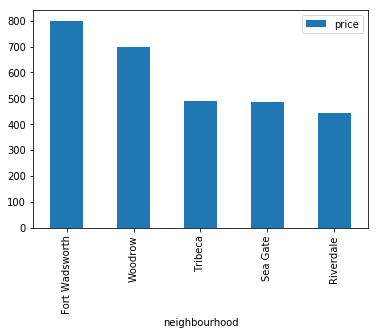

In [54]:
# average price by neighborhood top 5 
price_rank = raw_data[['neighbourhood', 'price']].groupby(['neighbourhood']).mean().sort_values(by = 'price', ascending = False)[: 5]
price_rank.plot.bar()


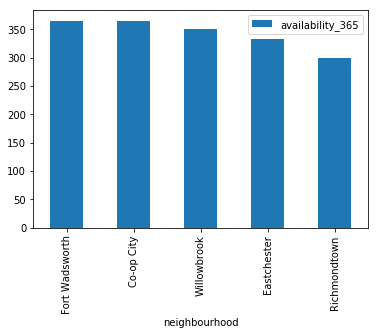

In [55]:
# average availability by neighborhood top 5
raw_data[['neighbourhood', 'availability_365']].groupby(['neighbourhood']).mean().sort_values(by = 'availability_365', ascending = False)[: 5].plot.bar()

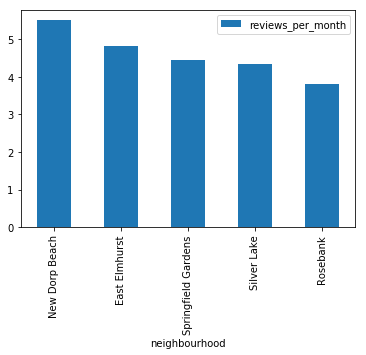

In [56]:
# average review per month by neighborhood top 5 to see popularity
raw_data[['neighbourhood', 'reviews_per_month']].groupby(['neighbourhood']).mean().sort_values(by = 'reviews_per_month', ascending = False)[: 5].plot.bar()

# 3. Modeling and Analysis <a name="Modeling and analysis"></a>

### 3.1 Clustering

##### 3.11 Data Cleaning

In [57]:

import datetime
# re-creating the training dataframe
df = raw_data.iloc[:, 6:]
df.head()
df.dropna(inplace = True)


In [58]:

# constructing days before last review to today
df['last_review'] = df['last_review'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df['last_review_days'] = df['last_review'].apply(lambda x: (x - datetime.datetime.now())).dt.days
df['last_review_days'] = df['last_review_days']*(-1)

In [59]:
df.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days
0,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,368
1,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,154
3,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,109
4,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,337
5,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,122


In [60]:

df_labeled = df
df_labeled.drop(columns = ['room_type', 'last_review'], inplace =True)
df_labeled.fillna(df_labeled.mean(), inplace = True)
df_labeled.head()


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days
0,40.64749,-73.97237,149,1,9,0.21,6,365,368
1,40.75362,-73.98377,225,1,45,0.38,2,355,154
3,40.68514,-73.95976,89,1,270,4.64,1,194,109
4,40.79851,-73.94399,80,10,9,0.10,1,0,337
5,40.74767,-73.97500,200,3,74,0.59,1,129,122


In [61]:
# scale the data
df_scaled = mms.fit_transform(df_labeled)


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### 3.12 finding best k value

In [62]:
from sklearn.cluster import KMeans 


In [80]:

# finding the best k
distance = []
k = []
for x in range(1,20):
    km = KMeans(x)
    km.fit(df_scaled)
    k.append(x)
    distance.append(km.inertia_)

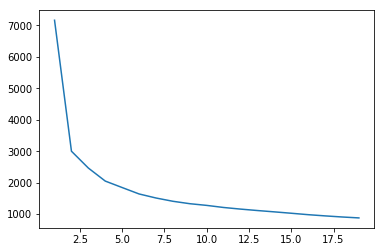

In [81]:
sb.lineplot(k, distance)

According to elbow method, the proper k value should be around 6

##### 3.13 KMeans model

In [82]:
# let's try k = 6
km = KMeans(6, random_state = 42)
km.fit(df_scaled)
df_final = df.copy()
df_final['cluster'] = km.labels_


In [83]:
df.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'last_review_days'],
      dtype='object')

Converting back the data

In [84]:
cluster_center = pd.DataFrame(mms.inverse_transform(km.cluster_centers_))
cluster_center.columns = df.columns
cluster_center

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days
0,40.730866,-73.949710,160.668998,6.808394,51.025593,1.991803,4.285446,204.502474,212.354718
1,40.730941,-73.956138,129.276627,4.631448,21.114731,1.173508,1.667675,8.837871,274.279342
2,40.725348,-73.942672,160.375179,8.961323,35.966141,1.522728,7.484959,327.855320,252.837479
3,40.717777,-74.003558,271.705128,7.653846,5.594017,1.723974,316.038462,287.564103,149.085470
4,40.722150,-73.940601,132.210321,4.852841,41.305714,2.221166,2.475989,89.300667,165.715286
5,40.729520,-73.961374,134.648219,4.624524,5.885667,0.132118,1.217564,2.719635,1176.340017


In [85]:
df_final['name'] = raw_data['name']
df_final.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days,cluster,name
0,40.64749,-73.97237,149,1,9,0.21,6,365,368,2,Clean & quiet apt home by the park
1,40.75362,-73.98377,225,1,45,0.38,2,355,154,2,Skylit Midtown Castle
3,40.68514,-73.95976,89,1,270,4.64,1,194,109,0,Cozy Entire Floor of Brownstone
4,40.79851,-73.94399,80,10,9,0.10,1,0,337,1,Entire Apt: Spacious Studio/Loft by central park
5,40.74767,-73.97500,200,3,74,0.59,1,129,122,4,Large Cozy 1 BR Apartment In Midtown East


##### 3.14 Visualize clustering

In [86]:
!pip install folium
import folium

In [87]:

cluster1 = df_final[df_final['cluster'] == 0].sort_values(by = ['reviews_per_month'], ascending = False).iloc[:10,:]
cluster2 = df_final[df_final['cluster'] == 1].sort_values(by = ['reviews_per_month'], ascending = False).iloc[:10,:]
cluster3 = df_final[df_final['cluster'] == 2].sort_values(by = ['reviews_per_month'], ascending = False).iloc[:10,:]
cluster4 = df_final[df_final['cluster'] == 3].sort_values(by = ['reviews_per_month'], ascending = False).iloc[:10,:]
cluster5 = df_final[df_final['cluster'] == 4].sort_values(by = ['reviews_per_month'], ascending = False).iloc[:10,:]
cluster6 = df_final[df_final['cluster'] == 5].sort_values(by = ['reviews_per_month'], ascending = False).iloc[:10,:]
cluster_center['name'] = pd.Series(cluster_center.index.values).apply(lambda x: 'Cluster Group ' + str(x))
cluster_center

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days,name
0,40.730866,-73.949710,160.668998,6.808394,51.025593,1.991803,4.285446,204.502474,212.354718,Cluster Group 0
1,40.730941,-73.956138,129.276627,4.631448,21.114731,1.173508,1.667675,8.837871,274.279342,Cluster Group 1
2,40.725348,-73.942672,160.375179,8.961323,35.966141,1.522728,7.484959,327.855320,252.837479,Cluster Group 2
3,40.717777,-74.003558,271.705128,7.653846,5.594017,1.723974,316.038462,287.564103,149.085470,Cluster Group 3
4,40.722150,-73.940601,132.210321,4.852841,41.305714,2.221166,2.475989,89.300667,165.715286,Cluster Group 4
5,40.729520,-73.961374,134.648219,4.624524,5.885667,0.132118,1.217564,2.719635,1176.340017,Cluster Group 5


In [88]:
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start = 12)

#add stickers based on clusters

for x,y,n in cluster_center[['latitude', 'longitude', 'name']].values.tolist():
    folium.Marker([x,y], tooltip=n, icon=folium.Icon(icon='cloud')).add_to(map)

for x,y,n in cluster1[['latitude', 'longitude', 'name']].values.tolist():
    folium.Marker([x,y], tooltip=n, icon=folium.Icon(color = 'red')).add_to(map)
for x,y,n in cluster2[['latitude', 'longitude', 'name']].values.tolist():
    folium.Marker([x,y], tooltip=n, icon=folium.Icon(color = 'blue')).add_to(map)
for x,y,n in cluster3[['latitude', 'longitude', 'name']].values.tolist():
    folium.Marker([x,y], tooltip=n, icon=folium.Icon(color = 'orange')).add_to(map)
for x,y,n in cluster4[['latitude', 'longitude', 'name']].values.tolist():
    folium.Marker([x,y], tooltip=n, icon=folium.Icon(color = 'pink')).add_to(map)
for x,y,n in cluster5[['latitude', 'longitude', 'name']].values.tolist():
    folium.Marker([x,y], tooltip=n, icon=folium.Icon(color = 'black')).add_to(map)
for x,y,n in cluster6[['latitude', 'longitude', 'name']].values.tolist():
    folium.Marker([x,y], tooltip=n, icon=folium.Icon()).add_to(map)


In [89]:
map # due to large number of clusters I only showed 5 clusters, but showed the centroids of all 16 groups with the icon 'cloud'

### 3.2 Clustering-based Recommendation System

Now let's work on how to select a group

Note this is not a collaborative filtering or content based filtering! This is a simple ranking method which only allow us to choose the one most important factor!

In [90]:
cluster_sc = cluster_center.copy()
cluster_sc['price'] = cluster_center['price'] * -1
cluster_sc['minimum_nights'] = cluster_center['minimum_nights'] * -1
cluster_sc['last_review_days'] = cluster_center['last_review_days'] * -1


In [91]:
criterion = cluster_sc.columns.values.tolist()[2:-1]
criterion

['price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'last_review_days']

In [92]:
for x in criterion:
    y = str(x) + ' rank'
    cluster_sc[y] = cluster_sc.reset_index().sort_values(by = x).reset_index()['level_0']
cluster_rank = cluster_sc.iloc[:, 9:]
cluster_rank

,name,price rank,minimum_nights rank,number_of_reviews rank,reviews_per_month rank,calculated_host_listings_count rank,availability_365 rank,last_review_days rank
0,Cluster Group 0,3,2,3,5,5,5,5
1,Cluster Group 1,0,3,5,1,1,1,1
2,Cluster Group 2,2,0,1,2,4,4,2
3,Cluster Group 3,5,4,2,3,0,0,0
4,Cluster Group 4,4,1,4,0,2,3,4
5,Cluster Group 5,1,5,0,4,3,2,3


In [93]:
def recommend(factors:list, weight:list, quant):
    factors_adj = []
    for a in factors:
        factors_adj.append(str(a) + ' rank')
    
    recomm_cluster = pd.DataFrame((cluster_rank[factors_adj]*weight).sum(axis = 1).sort_values(ascending = False))
    recomm_cluster_lst = recomm_cluster[recomm_cluster[0] == float(recomm_cluster.max().values)].index.tolist()
    recommended = []
    c_quant = round(quant/len(recomm_cluster_lst))
    for x in recomm_cluster_lst:
        recommended.append(df_final[df_final['cluster'] == x][:c_quant])
    return recommended

### 3.3 An Example Using the Recommendation System

##### 3.31 Modeling the Result

Suppose that we have a customer who are sensitive to price and the reviews_per_month equally, what should he or she choose?

In [94]:
factors = ['price','reviews_per_month']
weight = [0.5,0.5]

recommended = recommend(factors, weight , 100)
pd.concat(recommended, axis = 0).head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days,cluster,name
29128,40.70637,-74.00941,271,30,1,0.09,232,310,431,3,"Calming FiDi 1BR w/ lux Gym, Speakeasy + Doorm..."
30428,40.74891,-73.97887,305,30,1,0.17,232,326,280,3,"Posh Park Avenue 1BR w/ Gym, Doorman in Midtow..."
32788,40.77669,-73.95673,211,30,1,0.23,232,201,236,3,"Adorable UES Studio w/ Balcony, Gym + Doorman ..."
34048,40.76196,-73.98536,280,30,2,0.36,232,218,159,3,Enchanting 1BR near Times Sq w/ Indoor pool + ...
35411,40.70427,-74.00964,285,30,1,0.12,232,324,353,3,"Roomy FiDi 1BR w/ Gym, Roof deck + Doorman by ..."


In [95]:
cluster_recommended = pd.concat(recommended, axis = 0)['cluster'].unique()

print('number of clusters recommended: ', pd.concat(recommended, axis = 0)['cluster'].nunique())
print('the clusters recommended: ', cluster_recommended)

number of clusters recommended:  2
the clusters recommended:  [3 0]


Let's visualize it!

In [96]:
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start = 12)
colors = []
for color in folium.map.Icon().color_options:
    colors.append(color)
for c in range(len(recommended)):

    for x,y,n in recommended[c][['latitude', 'longitude',  'name']].values.tolist():
        folium.Marker([x,y], tooltip=n, icon=folium.Icon(color = colors[c])).add_to(m)

m

##### 3.32 Result and Analysis

In [97]:
print('cluster_recommended: ' ,cluster_recommended)


cluster_recommended:  [3 0]


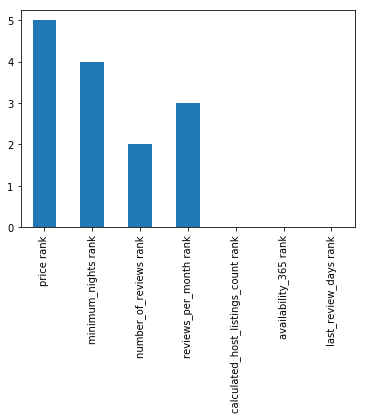

In [98]:
cluster_rank.iloc[3,1:].plot.bar()

The cluster 3 has a relatively well reviews per month score and a really good price sccore.

Note that the in the chart the Y-axis is the score value of the rank, and 5 means the cluster is the best in this particular aspect.

As the map suggests, if the customer cares about both price and the review, there are a variety of choices. On manhattan, the majority of the recommendations lies on Financial District, West Village, and East Village, where the housing price is relatively better. At the same time, per the personal experience, there are a lot of housing available in East Village as well. The community is cozy and quiet, and is very nice to live in. It's no wonder why it has the best score in the number of review, which suggests about the popularity of a place.

In Brooklyn, the maojority lies in Williamsburg and Downtown Brooklyn. Both are very popular place nowadays even for New Yorkers to live, and the price is much lower than on the manhattan.


# 4. Conclusion <a name="Conclusion"></a>

The purpose of this project is to build a model that could provide insights for people looking for airbnb in NYC through clustering analysis. The data comes mainly from Kaggle and the model is built mainly on Scikit-Learn. 

The recommendation system is based on clustering analysis. We use this version because we don't have access to enough data to make a content based filtering or collaborative filtering. As a result, we applied Clustering method of KMeans to group the choices, and then use weighted score depending on customer needs to choose the cluster. This isn't the most accurate way but it could provide insights for customers and save their time.Through this clustering analysis, customer could add their preference on the community by focusing on the area that they are interested in. The final decision would be made based on customer's other consideration


The model could be further improved by mining more data and features. For example, how long does it take to go from the house to the main tourist sites? How many good restaurant are there within reach? What's the safety issue there? More data could improve the clusters.

